In [1]:
# presentation: 5-7 minutes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib inline

In [3]:
# read in files
sat_17 = pd.read_csv('../data/sat_2017.csv')
act_17 = pd.read_csv('../data/act_2017.csv')
sat_18 = pd.read_csv('../data/sat_2018.csv')
act_18 = pd.read_csv('../data/act_2018.csv')

In [4]:
# make our participation rates floats
def part_float(df):
    df['Participation'] = df['Participation'].str.rstrip('%').astype('float') / 100.0
    
part_float(sat_17)
part_float(sat_18)
part_float(act_17)
part_float(act_18)

In [5]:
# check the format of the dataframes for SAT
sat_17.head()

,State,Participation,Evidence-Based Reading and Writing,Math,Total
0,Alabama,0.05,593,572,1165
1,Alaska,0.38,547,533,1080
2,Arizona,0.30,563,553,1116
3,Arkansas,0.03,614,594,1208
4,California,0.53,531,524,1055


In [6]:
sat_18.head()

,State,Participation,Evidence-Based Reading and Writing,Math,Total
0,Alabama,0.06,595,571,1166
1,Alaska,0.43,562,544,1106
2,Arizona,0.29,577,572,1149
3,Arkansas,0.05,592,576,1169
4,California,0.60,540,536,1076


In [7]:
# Those look good. ACT?
act_17.head()

,State,Participation,English,Math,Reading,Science,Composite
0,National,0.60,20.3,20.7,21.4,21.0,21.0
1,Alabama,1.00,18.9,18.4,19.7,19.4,19.2
2,Alaska,0.65,18.7,19.8,20.4,19.9,19.8
3,Arizona,0.62,18.6,19.8,20.1,19.8,19.7
4,Arkansas,1.00,18.9,19.0,19.7,19.5,19.4


In [8]:
act_18.head()
# Looks like any ACT comparisons for 2018 will be composite score only

,State,Participation,Composite
0,Alabama,1.00,19.1
1,Alaska,0.33,20.8
2,Arizona,0.66,19.2
3,Arkansas,1.00,19.4
4,California,0.27,22.7


In [9]:
# So, we might as well drop the extra columns in our 2017 data
act_17 = act_17.drop(['English','Math','Reading','Science'],axis=1)
act_17.head()

,State,Participation,Composite
0,National,0.60,21.0
1,Alabama,1.00,19.2
2,Alaska,0.65,19.8
3,Arizona,0.62,19.7
4,Arkansas,1.00,19.4


In [10]:
act_18[act_18['State']=='National']
# It also looks like this year the "National" entry got moved.

,State,Participation,Composite
51,National,0.55,20.8


In [11]:
# I'll just move 'National' to the top so it lines up with 'National' 2017

target_row = 51
# Move target row to first element of list.
idx = [target_row] + [i for i in range(len(act_18)) if i != target_row]

# Re-order the dataframe by idx, reset the index so it makes sense, then drop the old index column
# (which apparently is kept after calling reset_index()... who knew?)
act_18 = act_18.iloc[idx].reset_index().drop(['index'],axis=1)
act_18.head()

,State,Participation,Composite
0,National,0.55,20.8
1,Alabama,1.00,19.1
2,Alaska,0.33,20.8
3,Arizona,0.66,19.2
4,Arkansas,1.00,19.4


In [12]:
#okay, so let's take a look at our columns
act_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
State            52 non-null object
Participation    52 non-null float64
Composite        52 non-null object
dtypes: float64(1), object(2)
memory usage: 1.3+ KB


In [13]:
act_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
State            52 non-null object
Participation    52 non-null float64
Composite        52 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.3+ KB


In [14]:
sat_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
State                                 51 non-null object
Participation                         51 non-null float64
Evidence-Based Reading and Writing    51 non-null int64
Math                                  51 non-null int64
Total                                 51 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB


In [15]:
sat_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
State                                 51 non-null object
Participation                         51 non-null float64
Evidence-Based Reading and Writing    51 non-null int64
Math                                  51 non-null int64
Total                                 51 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB


In [16]:
# We'll have to fix that Composite score for act_17, but that gives us an error because of some bad data for 
# Wyoming. I'll have to replace that one manually.

act_17['Composite'][51] = '20.2'
act_17['Composite'] = [float(i) for i in act_17['Composite']]

/Users/brianb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
act_17.head()

,State,Participation,Composite
0,National,0.60,21.0
1,Alabama,1.00,19.2
2,Alaska,0.65,19.8
3,Arizona,0.62,19.7
4,Arkansas,1.00,19.4


In [18]:
# Now I'll put in some national averages so our SAT and ACT dataframes together will line up perfectly.
# First I'll have to add in National scores to the SAT data:

national = pd.DataFrame(columns=['State','Participation','Evidence-Based Reading and Writing',
                         'Math','Total'])
national.loc[0] = ['National',np.nan,np.nan,np.nan,np.nan]
def set_avg(df):
    for i in df.columns[1:]:
        national[i][0] = np.mean(df[i])
        if i != 'Participation':
            national[i][0] = round(national[i][0])
        else:
            national[i][0] = round(national[i][0],2)
        
set_avg(sat_17)
sat_17 = sat_17.append(national)
set_avg(sat_18)
sat_18 = sat_18.append(national)

In [19]:
# Second, I'll move the 'National' entries to the top to line up with the ACT tables
# I can do that the same way as the act_18 movement above

target_row = 51

idx = [target_row] + [i for i in range(len(sat_17)) if i != target_row]
sat_17 = sat_17.iloc[idx].reset_index().drop(['index'],axis=1)

idx = [target_row] + [i for i in range(len(sat_18)) if i != target_row]
sat_18 = sat_18.iloc[idx].reset_index().drop(['index'],axis=1)

In [20]:
sat_18.head()

,State,Participation,Evidence-Based Reading and Writing,Math,Total
0,National,0.46,564,556,1120
1,Alabama,0.06,595,571,1166
2,Alaska,0.43,562,544,1106
3,Arizona,0.29,577,572,1149
4,Arkansas,0.05,592,576,1169


In [21]:
sat_17.head()

,State,Participation,Evidence-Based Reading and Writing,Math,Total
0,National,0.4,569,548,1126
1,Alabama,0.05,593,572,1165
2,Alaska,0.38,547,533,1080
3,Arizona,0.3,563,553,1116
4,Arkansas,0.03,614,594,1208


In [22]:
sat_17.dtypes

State                                 object
Participation                         object
Evidence-Based Reading and Writing    object
Math                                  object
Total                                 object
dtype: object

In [23]:
# Making the SAT columns the right types

sat_17['Evidence-Based Reading and Writing']=sat_17['Evidence-Based Reading and Writing'].astype('float')
sat_17['Math']=sat_17['Math'].astype('float')
sat_17['Total']=sat_17['Total'].astype('float')
sat_17['Participation']=sat_17['Participation'].astype('float')
sat_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 5 columns):
State                                 52 non-null object
Participation                         52 non-null float64
Evidence-Based Reading and Writing    52 non-null float64
Math                                  52 non-null float64
Total                                 52 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [24]:
sat_18['Evidence-Based Reading and Writing']=sat_18['Evidence-Based Reading and Writing'].astype('float')
sat_18['Math']=sat_18['Math'].astype('float')
sat_18['Total']=sat_18['Total'].astype('float')
sat_18['Participation']=sat_18['Participation'].astype('float')
sat_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 5 columns):
State                                 52 non-null object
Participation                         52 non-null float64
Evidence-Based Reading and Writing    52 non-null float64
Math                                  52 non-null float64
Total                                 52 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


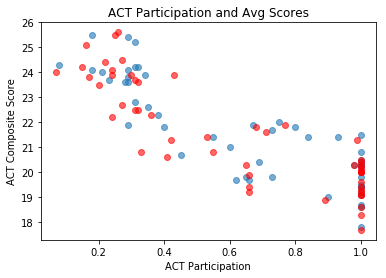

In [25]:
#basic plot of ACT score/participation change between '17 and '18

fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('ACT Participation and Avg Scores')
plt.xlabel('ACT Participation')
plt.ylabel('ACT Composite Score')
ax1.plot(act_17['Participation'],act_17['Composite'],alpha=.6,linestyle='none',marker='o')
ax1.plot(act_18['Participation'],act_18['Composite'],alpha=.6,color='r',linestyle='none',marker='o')

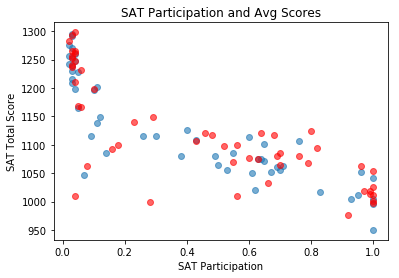

In [26]:
# same with SAT data

#basic plot of ACT score/participation change between '17 and '18

fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('SAT Participation and Avg Scores')
plt.xlabel('SAT Participation')
plt.ylabel('SAT Total Score')
ax1.plot(sat_17['Participation'],sat_17['Total'],alpha=.6,linestyle='none',marker='o')
ax1.plot(sat_18['Participation'],sat_18['Total'],alpha=.6,color='r',linestyle='none',marker='o')

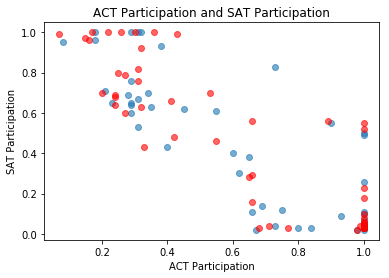

In [27]:
# Let's see how states' participation in one test affects the other

#basic plot of ACT score/participation change between '17 and '18

fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('ACT Participation and SAT Participation')
plt.xlabel('ACT Participation')
plt.ylabel('SAT Participation')
ax1.plot(act_17['Participation'],sat_17['Participation'],alpha=.6,linestyle='none',marker='o')
ax1.plot(act_18['Participation'],sat_18['Participation'],alpha=.6,color='r',linestyle='none',marker='o')

## Perfect!

I think my project will be about competing participation rates between the two test administration... companies? Organizations? Whatever they're called. This will be fun!

In [28]:
# Second attempt at taking the SAT data and drawing connecting lines to show which states had what change in
# participation and average score

# I think this may go most smoothly by making a new dataframe

sat_data = pd.DataFrame(columns=['State','Participation_17','Participation_18', 'Participation_Change',
                                 'Total_Score_17','Total_Score_18','Total_Score_Change'])
sat_data['State'] = sat_17['State']
sat_data['Participation_17'] = sat_17['Participation']
sat_data['Participation_18'] = sat_18['Participation']
sat_data['Participation_Change'] = sat_data['Participation_18'] - sat_data['Participation_17']
sat_data['Total_Score_17'] = sat_17['Total']
sat_data['Total_Score_18'] = sat_18['Total']
sat_data['Total_Score_Change'] = sat_data['Total_Score_18'] - sat_data['Total_Score_17']
sat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 7 columns):
State                   52 non-null object
Participation_17        52 non-null float64
Participation_18        52 non-null float64
Participation_Change    52 non-null float64
Total_Score_17          52 non-null float64
Total_Score_18          52 non-null float64
Total_Score_Change      52 non-null float64
dtypes: float64(6), object(1)
memory usage: 2.9+ KB


In [29]:
sat_data.head(10)

,State,Participation_17,Participation_18,Participation_Change,Total_Score_17,Total_Score_18,Total_Score_Change
0,National,0.40,0.46,0.06,1126.0,1120.0,-6.0
1,Alabama,0.05,0.06,0.01,1165.0,1166.0,1.0
2,Alaska,0.38,0.43,0.05,1080.0,1106.0,26.0
3,Arizona,0.30,0.29,-0.01,1116.0,1149.0,33.0
4,Arkansas,0.03,0.05,0.02,1208.0,1169.0,-39.0
5,California,0.53,0.60,0.07,1055.0,1076.0,21.0
6,Colorado,0.11,1.00,0.89,1201.0,1025.0,-176.0
7,Connecticut,1.00,1.00,0.00,1041.0,1053.0,12.0
8,Delaware,1.00,1.00,0.00,996.0,998.0,2.0
9,District of Columbia,1.00,0.92,-0.08,950.0,977.0,27.0


In [30]:
# I like that format a lot! Let's make one for ACT data

act_data = pd.DataFrame(columns=['State','Participation_17','Participation_18', 'Participation_Change',
                                 'Composite_Score_17','Composite_Score_18','Composite_Score_Change'])
act_data['State'] = act_17['State']
act_data['Participation_17'] = act_17['Participation']
act_data['Participation_18'] = act_18['Participation']
act_data['Participation_Change'] = act_data['Participation_18'] - act_data['Participation_17']
act_data['Composite_Score_17'] = act_17['Composite']
act_data['Composite_Score_18'] = act_18['Composite']
act_data['Composite_Score_Change'] = act_data['Composite_Score_18'] - act_data['Composite_Score_17']
act_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 7 columns):
State                     52 non-null object
Participation_17          52 non-null float64
Participation_18          52 non-null float64
Participation_Change      52 non-null float64
Composite_Score_17        52 non-null float64
Composite_Score_18        52 non-null float64
Composite_Score_Change    52 non-null float64
dtypes: float64(6), object(1)
memory usage: 2.9+ KB


In [31]:
# Since I like these so much, I'll just save them and use them in the final project

sat_data.to_csv(path_or_buf='../data/sat_data')
act_data.to_csv(path_or_buf='../data/act_data')

In [32]:
# Now let's see some states with big changes

sat_data['Part_Change_Abs'] = sat_data['Participation_Change'].abs()
sat_data.sort_values('Part_Change_Abs',ascending=False).head(10).drop('Part_Change_Abs', axis=1)

,State,Participation_17,Participation_18,Participation_Change,Total_Score_17,Total_Score_18,Total_Score_Change
14,Illinois,0.09,0.99,0.90,1115.0,1019.0,-96.0
6,Colorado,0.11,1.00,0.89,1201.0,1025.0,-176.0
10,Florida,0.83,0.56,-0.27,1017.0,1099.0,82.0
40,Rhode Island,0.71,0.97,0.26,1062.0,1018.0,-44.0
49,West Virginia,0.14,0.28,0.14,1086.0,999.0,-87.0
31,New Jersey,0.70,0.82,0.12,1056.0,1094.0,38.0
33,New York,0.67,0.79,0.12,1052.0,1068.0,16.0
11,Georgia,0.61,0.70,0.09,1050.0,1064.0,14.0
9,District of Columbia,1.00,0.92,-0.08,950.0,977.0,27.0
21,Maryland,0.69,0.76,0.07,1060.0,1080.0,20.0


In [33]:
# A good year for the SAT! Looks like more participants were gained than lost among the biggest states. I suppose
# we ought to look at the national average (though this data doesn't account for population totals, just rates...)

sat_data.loc[sat_data['State']=='National']

,State,Participation_17,Participation_18,Participation_Change,Total_Score_17,Total_Score_18,Total_Score_Change,Part_Change_Abs
0,National,0.4,0.46,0.06,1126.0,1120.0,-6.0,0.06


In [34]:
# Cool. Let's look at the same stuff for ACT:

act_data['Part_Change_Abs'] = act_data['Participation_Change'].abs()
act_data.sort_values('Part_Change_Abs',ascending=False).head(10).drop('Part_Change_Abs', axis=1)

,State,Participation_17,Participation_18,Participation_Change,Composite_Score_17,Composite_Score_18,Composite_Score_Change
6,Colorado,1.00,0.30,-0.70,20.8,23.9,3.1
14,Illinois,0.93,0.43,-0.50,21.4,23.9,2.5
2,Alaska,0.65,0.33,-0.32,19.8,20.8,1.0
36,Ohio,0.75,1.00,0.25,22.0,20.3,-1.7
28,Nebraska,0.84,1.00,0.16,21.4,20.1,-1.3
23,Michigan,0.29,0.22,-0.07,24.1,24.4,0.3
10,Florida,0.73,0.66,-0.07,19.8,19.9,0.1
40,Rhode Island,0.21,0.15,-0.06,24.0,24.2,0.2
47,Virginia,0.29,0.24,-0.05,23.8,23.9,0.1
7,Connecticut,0.31,0.26,-0.05,25.2,25.6,0.4


In [35]:
act_data.loc[act_data['State']=='National']

,State,Participation_17,Participation_18,Participation_Change,Composite_Score_17,Composite_Score_18,Composite_Score_Change,Part_Change_Abs
0,National,0.6,0.55,-0.05,21.0,20.8,-0.2,0.05


In [36]:
# Hmm... I see that not all the top states match up. I suppose factors are at play other than "are students on
# average taking the SAT or the ACT in this state?". Let's see how they correlate

sat_data['Participation_Change'].corr(act_data['Participation_Change'])

-0.8055246039287288

In [37]:
# Still pretty good! A Fairly Strong negative correlation. I think this kind of thing will make the final point
# of my presentation, and the main deal will be looking at the change across our two years. I think that will be
# a cool plot. I'll need to 1) have a scatterplot of the 2017 data, 2) layer on a scatterplot of 2018 data,
# 3) draw some grey lines connecting each state's points, then 4) color the lines based on positive or negative
# change (possibly with thickness based on the amount changed?)

''

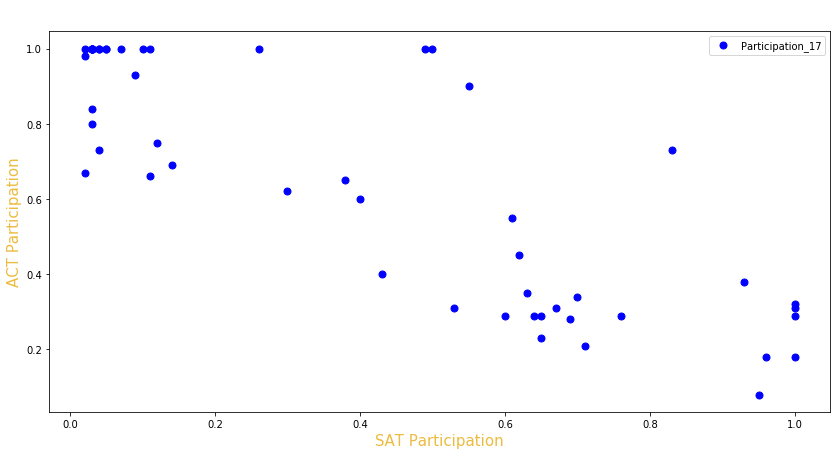

In [63]:
# 1) Graph the sat_17 Participation and Totale Score data

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(111)

plt.title('SAT State Averages in 2017',fontdict={'fontsize':25},color='#FFFFFF')
plt.xlabel('SAT Participation',fontdict={'fontsize':15},color='#ECBC40')
plt.ylabel('ACT Participation',fontdict={'fontsize':15},color='#ECBC40')
ax1.plot(sat_data['Participation_17'],act_data['Participation_17'],
         alpha=1,linestyle='none',marker='o',color='b',markersize=7)
ax1.legend()
;

''

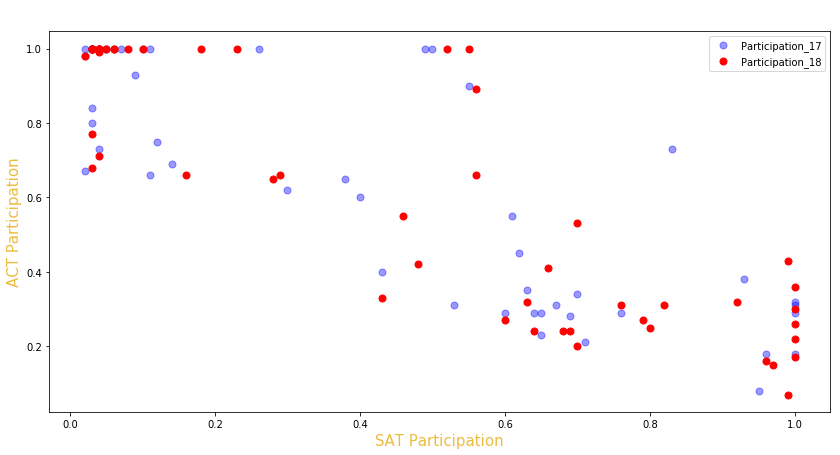

In [62]:
# 2) Layer the 2018 data

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(111)

plt.title('SAT State Averages in 2017 and 2018',fontdict={'fontsize':25},color='#FFFFFF')
plt.xlabel('SAT Participation',fontdict={'fontsize':15},color='#ECBC40')
plt.ylabel('ACT Participation',fontdict={'fontsize':15},color='#ECBC40')
ax1.plot(sat_data['Participation_17'],act_data['Participation_17'],
         alpha=.4,linestyle='none',marker='o',color='b',markersize=7)
ax1.plot(sat_data['Participation_18'],act_data['Participation_18'],
         alpha=1,linestyle='none',marker='o',color='r',markersize=7)
ax1.legend()
;

''

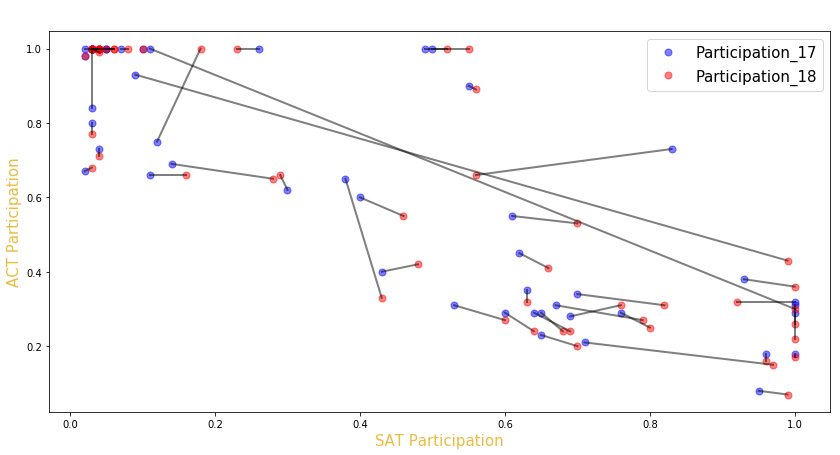

In [64]:
# Let's try drawing in those lines! Last time I tried this it caused no small amount of headache...

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(111)

plt.title('SAT State Averages in 2017 and 2018',fontdict={'fontsize':25},color='#FFFFFF')
plt.xlabel('SAT Participation',fontdict={'fontsize':15},color='#ECBC40')
plt.ylabel('ACT Participation',fontdict={'fontsize':15},color='#ECBC40')
ax1.plot(sat_data['Participation_17'],act_data['Participation_17'],
         alpha=.5,linestyle='none',marker='o',color='b',markersize=7)
ax1.plot(sat_data['Participation_18'],act_data['Participation_18'],
         alpha=.5,linestyle='none',marker='o',color='r',markersize=7)

for state in sat_data['State']:
    ax1.plot(
        [float(sat_data['Participation_17'].loc[sat_data['State']==state]),
          float(sat_data['Participation_18'].loc[sat_data['State']==state])],
         [float(act_data['Participation_17'].loc[act_data['State']==state]),
          float(act_data['Participation_18'].loc[act_data['State']==state])],
        color = 'k',alpha=.5,linewidth=2
        )


ax1.legend(fontsize=15)
;

''

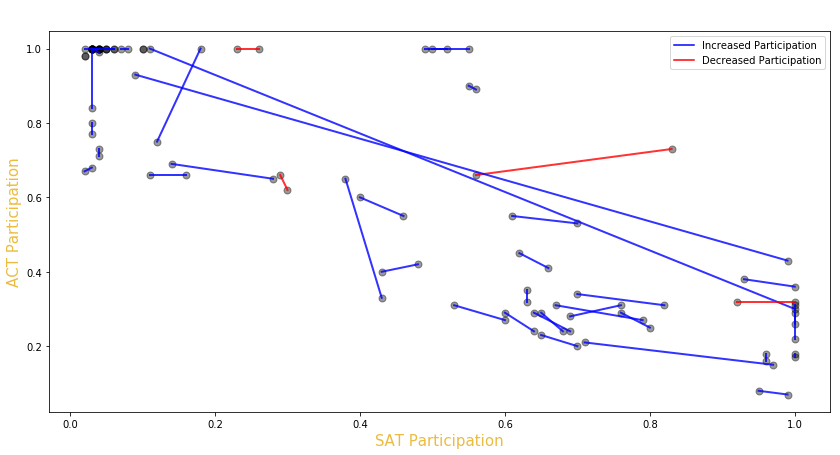

In [65]:
# Lastly, let's look at those sweet colors!

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(111)

plt.title('Participation Changes from 2017 to 2018',fontdict={'fontsize':25},color='#FFFFFF')
plt.xlabel('SAT Participation',fontdict={'fontsize':15},color='#ECBC40')
plt.ylabel('ACT Participation',fontdict={'fontsize':15},color='#ECBC40')
ax1.plot(sat_data['Participation_17'],act_data['Participation_17'],
         alpha=.4,linestyle='none',marker='o',color='k',markersize=7)
ax1.plot(sat_data['Participation_18'],act_data['Participation_18'],
         alpha=.4,linestyle='none',marker='o',color='k',markersize=7)

for state in sat_data['State']:
    if float(sat_data['Participation_Change'].loc[sat_data['State']==state]) >= 0:
        change_col = 'b'
    else:
        change_col = 'r'
    ax1.plot(
        [float(sat_data['Participation_17'].loc[sat_data['State']==state]),
          float(sat_data['Participation_18'].loc[sat_data['State']==state])],
         [float(act_data['Participation_17'].loc[act_data['State']==state]),
          float(act_data['Participation_18'].loc[act_data['State']==state])],
        color = change_col,linewidth=2,alpha=.8
        )

legend_lines = [Line2D([0], [0], color='b'),
                Line2D([0], [0], color='r')]
ax1.legend(legend_lines, ['Increased Participation', 'Decreased Participation'])
;

''

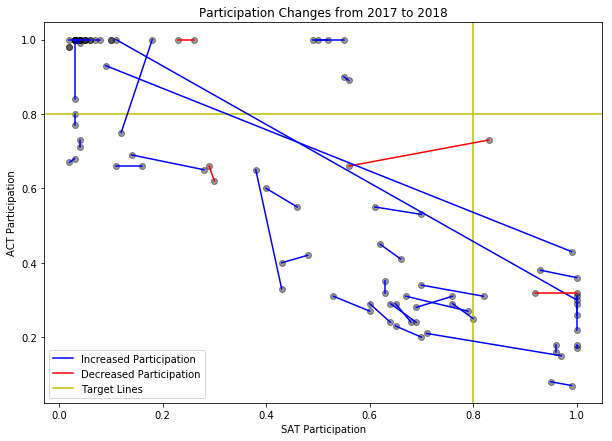

In [42]:
# This may get 'busy', but what if we draw in a line for determining who we should focus on.

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)

plt.title('Participation Changes from 2017 to 2018')
plt.xlabel('SAT Participation')
plt.ylabel('ACT Participation')
ax1.plot(sat_data['Participation_17'],act_data['Participation_17'],alpha=.4,linestyle='none',marker='o',color='k')
ax1.plot(sat_data['Participation_18'],act_data['Participation_18'],alpha=.4,linestyle='none',marker='o',color='k')

ax1.axhline(y=.8, color='y')
ax1.axvline(x=.8, color='y')

for state in sat_data['State']:
    if float(sat_data['Participation_Change'].loc[sat_data['State']==state]) >= 0:
        change_col = 'b'
    else:
        change_col = 'r'
    ax1.plot(
        [float(sat_data['Participation_17'].loc[sat_data['State']==state]),
          float(sat_data['Participation_18'].loc[sat_data['State']==state])],
         [float(act_data['Participation_17'].loc[act_data['State']==state]),
          float(act_data['Participation_18'].loc[act_data['State']==state])],
        color = change_col
        )

legend_lines = [Line2D([0], [0], color='b'),
                Line2D([0], [0], color='r'),
               Line2D([0], [0], color='y')]
ax1.legend(legend_lines, ['Increased Participation', 'Decreased Participation','Target Lines'])
;

In [43]:
sat_data.sort_values('Participation_Change')

,State,Participation_17,Participation_18,Participation_Change,Total_Score_17,Total_Score_18,Total_Score_Change,Part_Change_Abs
10,Florida,0.83,0.56,-0.27,1017.0,1099.0,82.0,0.27
9,District of Columbia,1.00,0.92,-0.08,950.0,977.0,27.0,0.08
29,Nevada,0.26,0.23,-0.03,1116.0,1140.0,24.0,0.03
3,Arizona,0.30,0.29,-0.01,1116.0,1149.0,33.0,0.01
18,Kentucky,0.04,0.04,0.00,1247.0,1248.0,1.0,0.00
17,Kansas,0.04,0.04,0.00,1260.0,1265.0,5.0,0.00
50,Wisconsin,0.03,0.03,0.00,1291.0,1294.0,3.0,0.00
15,Indiana,0.63,0.63,0.00,1074.0,1074.0,0.0,0.00
27,Montana,0.10,0.10,0.00,1196.0,1198.0,2.0,0.00
28,Nebraska,0.03,0.03,0.00,1253.0,1252.0,-1.0,0.00
